In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import wandb
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import torch

In [61]:
# Definir la arquitectura de la CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Canales de entrada, Canales de salida, Tamaño de Kernel, Stride y Padding
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 2)
        self.conv2 = nn.Conv2d(16, 64, 3, 1, 1) 
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        #Entrada (batch, channels, ancho, largo)
        # (64, 3, 32, 32)
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2) # No es una capa aprendible. (feature_maps, stride, padding)
        # (64, 16, 16, 16)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        # (64, 64, 8, 8)
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 2, 2)
        # (64, 128, 4, 4)
        x = x.view(-1, 128 * 4 * 4)
        # (64, 2048)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Definir la arquitectura de la CNN
class CNNSimpleUno(nn.Module):
    def __init__(self):
        super(CNNSimpleUno, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3,1,2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 8, 8)

        x = self.dropout(x)

        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Definir la arquitectura de la CNN
class CNNSimpleDos(nn.Module):
    def __init__(self):
        super(CNNSimpleDos, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,1,2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) 

        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):

        x = torch.relu(self.conv1(x))

        x = torch.max_pool2d(x, 4, 4)
       

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)
        x = torch.max_pool2d(x, 4, 4)
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
  

In [60]:


# directorio para leer los datos

data_dir = 'C:/Users/tian_/Desktop/Proyecto2/Data/raw'

transform = transforms.Compose([
    # convert the images to tensor shape
    transforms.ToTensor(),
    # Transformrs the images to 128 x 128, se hace porque no son constantes los tamaños
    transforms.Resize((32, 32)),
    # se normalizan los canales RGB la media y la deviacion stander en 0.5 cada canal
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Data Loader carga del folder de training las imagenes y las etiqueta con el nombre del folder donde estan
# en este caso Covid, Normal y Viral Pneumonia
trainset = datasets.ImageFolder(os.path.join(data_dir, 'training_set'), transform=transform)
testset = datasets.ImageFolder(os.path.join(data_dir, 'test_set'), transform=transform)
#Iterable del dataset

# probar con 32 or 64 for better results
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)


#Iterable del dataset
testloader = DataLoader(testset, batch_size=32, shuffle=False)



# se encuenta el numero de ejemplos, el numero de batch preselecionado y se calculan el total de numero de batceh por epoca
total_samples = len(trainloader.dataset)
batch_size = trainloader.batch_size
num_batches_per_epoch = math.ceil(total_samples / batch_size)

print("Total samples:", total_samples)
print("Batch size:", batch_size)
print("Number of batches per epoch:", num_batches_per_epoch)

Total samples: 1506
Batch size: 578
Number of batches per epoch: 3


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Is Torch Cuda Available? " + str(torch.cuda.is_available()))

Is Torch Cuda Available? True


In [27]:
def train(network,  criterion, optimizer, trainloader):
    network.train() # Se asigna el the modelo a train mode
    running_loss = 0.0
    #correctos y torales para el acurracy
    correct = 0
    total = 0
    # Entrenamiento del modelo
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        # Se calcula el loss actual 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
         #Para el accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        
        correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(trainloader), accuracy

def validate(network,  criterion, testloader):
    network.eval()  # Se asigna el the modelo a evaluation mode
    total_loss = 0.0
    #correctos y torales para el acurracy
    correct = 0
    total = 0
    # Y correctos y la Y predicion matrix de confusion
    y_true = []
    y_pred = []
    # Testeo del modelo
    with torch.no_grad():  # Disable gradient computation during validation
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            # Se calcula el loss actual 
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            #Para el accuracy
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            #matrix de confusion
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(testloader)
    return avg_loss, accuracy,y_true,y_pred

In [62]:


# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "ea93e82127178cd6709c03f277029a17909d3cbc"
wandb.login()

# Hyperparametros de entrenamiento
epochs = 10
lr = 0.0005
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

#Se inicializa la red y se escoge la funcion de perdida y la de optimizacion
network = CNNSimpleDos().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr)

# Log the network weight histograms (optional)
wandb.watch(network, log="all")


start_time = time.time()
for epoch in range(1, epochs+1):
    
    loss_train, acc_train = train(network,  criterion, optimizer, trainloader)
    loss_valid, acc_valid,y_true,y_pred = validate(network,  criterion, testloader)
    
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))

    # Logs en tiempo real de wandb
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Elapsed time:":time.time() - start_time})
    
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=y_true,
                                                                preds=y_pred,
                                                                class_names=class_names,
                                                                title = "CannyFilter Confusion Matrix")},
                                                                commit=False)
    
   






wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch: 1  Train Loss: 1.0612  Train Acc: 37.0518  Valid Loss: 0.9891  Valid Acc: 70.7071
Epoch: 2  Train Loss: 0.8850  Train Acc: 77.6892  Valid Loss: 0.8485  Valid Acc: 65.9091
Epoch: 3  Train Loss: 0.6928  Train Acc: 75.6308  Valid Loss: 0.6661  Valid Acc: 74.4949
Epoch: 4  Train Loss: 0.5225  Train Acc: 82.1381  Valid Loss: 0.6187  Valid Acc: 68.6869
Epoch: 5  Train Loss: 0.4446  Train Acc: 84.3293  Valid Loss: 0.5915  Valid Acc: 72.2222
Epoch: 6  Train Loss: 0.3931  Train Acc: 83.7981  Valid Loss: 0.5463  Valid Acc: 78.5354
Epoch: 7  Train Loss: 0.3794  Train Acc: 85.9894  Valid Loss: 0.5887  Valid Acc: 74.4949
Epoch: 8  Train Loss: 0.3304  Train Acc: 86.1222  Valid Loss: 0.4844  Valid Acc: 82.0707
Epoch: 9  Train Loss: 0.3022  Train Acc: 89.0438  Valid Loss: 0.5693  Valid Acc: 75.0000
Epoch: 10  Train Loss: 0.2914  Train Acc: 88.9774  Valid Loss: 0.4412  Valid Acc: 83.0808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


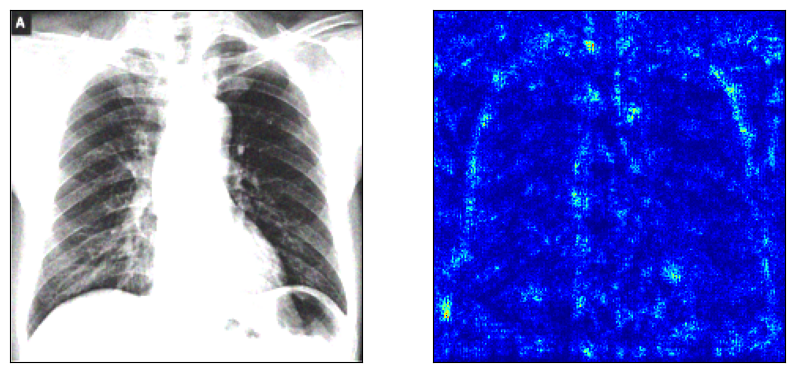

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import  torchvision.transforms as transforms

 #Define transforms for preprocessing input image into a format expected by the model
normalize = transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust normalization parameters for thermal images

# Inverse transform to get the normalized image back to its original form for visualization
inv_normalize = transforms.Normalize(mean=[-1], std=[1])

# Transforms to resize image to the size expected by the model, convert PIL image to tensor, and normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])


def saliency(img, model):
    # Get the device of the model
    device = next(model.parameters()).device
    
    # Set the model to evaluation mode
    model.eval()
    
    # Transform input PIL image to torch.Tensor and normalize
    input = transform(img).to(device)  # Move input tensor to the same device as the model
    input.unsqueeze_(0)
    input.requires_grad = True
    
    # Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    
    # Define a dummy loss (scalar) for gradient computation
    dummy_loss = score.sum()  # Summing up the scores to make it a scalar
    
    # Backward pass to get gradients of the dummy loss w.r.t. input image
    dummy_loss.backward()
    
    # Get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # Normalize to [0..1]
    slc = (slc - slc.min()) / (slc.max() - slc.min())

    # Apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    # Plot image and its saliency map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))  # Move tensor to CPU for visualization
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.jet)  # Move tensor to CPU for visualization
    plt.xticks([])
    plt.yticks([])
    plt.show()

img = Image.open('01.jpeg')
saliency(img, network)



In [ ]:
https://discuss.pytorch.org/t/understanding-transform-normalize/21730

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

https://www.geeksforgeeks.org/python-loop-through-folders-and-files-in-directory/

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://imgaug.readthedocs.io/en/latest/source/overview/meta.html

https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb